In [1]:
# from spacy import load, prefer_gpu 
from helpers import get_dates_from_file
from glob import glob
from tqdm import tqdm
from datetime import datetime
import pandas as pd 
from spacy import load, prefer_gpu
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
# !pip install https://huggingface.co/csae8092/de_MRP_NER/resolve/main/de_MRP_NER-any-py3-none-any.whl --user
tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner-with-dates")
model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/camembert-ner-with-dates")
prefer_gpu()

# Parameters
useSpacy = True
folder = "./results/NYT/1920"
language = "en"
model_dict = {
    "fr" : pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple", device = 0),
    #"de" : load("de_RTA_NER"),
    # "en" : load("en_core_web_sm")

}

nlp = model_dict[language]

C:\Users\bench\anaconda3\envs\p38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\bench\anaconda3\envs\p38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\bench\anaconda3\envs\p38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [5]:
# Compute the results from the previously created files (using fileCreater.ipynb)

results = []
nb = []
for file in tqdm(glob(folder + "/*/*.csv")):        # Compute the nb of dates
    results.append(get_dates_from_file(file,nlp,useSpacy,rt = 0.75, lt = 15))
for file in tqdm(glob(folder + "/*/*.csv")): # Get the length of the text from each date
    nb.append(pd.read_csv(file)["Length"].sum())
df = pd.DataFrame(results, columns = ["Date", "Number of dates"])

100%|██████████| 364/364 [00:01<00:00, 285.93it/s]


,Date,Number of dates,length,ratio
0,1898-01-01,19,24768,NaN
1,1898-01-02,40,29908,NaN
2,1898-01-03,55,26348,NaN
3,1898-01-04,33,28882,NaN
4,1898-01-05,25,27258,NaN
...,...,...,...,...
359,1898-12-27,31,28254,0.001133
360,1898-12-28,36,26889,0.001153
361,1898-12-29,29,25654,0.001169
362,1898-12-30,48,26683,0.001195


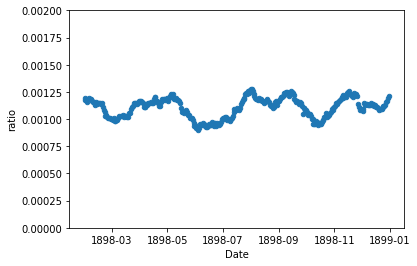

In [10]:
# Plotting the results
df["length"] = nb
df["ratio"] = (df["Number of dates"]/df["length"]).rolling(window = 30).mean() # You can configure the rolling average window size, default 8
df.plot(x= "Date", y = "ratio", kind = "scatter", ylim = (0,0.002))
df

In [2]:
results = []
def get_doc_from_file(filepath, pipeline,spacy, rt = 0.75,lt = 15 ): 
    """
    Arguments : 
        - filepath : path of the file 
            The file path has to be of the form ./things/YYYY_MM__DD.csv, for example "./results/1920_10_01.csv"    
        - pipeline : spaCy pipeline ttah performs the NER
        - rt : Word ratio threshold under which we do not consider the text block 
            range : [0,1]
        - lt : Length threshold under which we do not consider the text block 
            range : (0,inf)
    Return : 
        - date: date at which the newspaper was issued
        - nb_dates : number of dates appearing in the file
        
    """
    res  = []
    date  = datetime.strptime(filepath[-14:-4], "%Y\\%m\\%d")
    df = pd.read_csv(filepath)
    filtered_df = df[(df.Length > lt) & (df.Ratio > rt)]
    processed_docs = [pipeline(block) for block in list(filtered_df["Text"])]
    for doc in processed_docs:
        if len([ e for e in doc.ents if e.label_ == "DATE"]) > 0 :
            res.append(doc)
    return res
for file in tqdm(glob(folder + "/*/*.csv")): 
    results += get_doc_from_file(file, nlp,True)

 36%|███▌      | 33/92 [13:28<31:47, 32.33s/it]

KeyboardInterrupt: 

In [5]:
results
with open("Ner.txt", "w") as f:
    for item in results:
        f.write(str(item)+ "\n")